In [119]:
from matplotlib import pyplot as plt
from PIL import Image
import json
import numpy as np
import albumentations as A
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [115]:
def recall_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = TP / (Positives+K.epsilon())    
    return recall 

def precision_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision 
    
def f1(y_true, y_pred):        
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [84]:
train_ub = "uboatnet-processed/train"
valid_ub = "uboatnet-processed/valid"
train_or = "original-processed/train"
valid_or = "original-processed/valid"
labels_ub = json.load(open("uboatnet-processed-labels.json", "r"))
labels_or = json.load(open("original-processed-labels.json", "r"))

NUM_CLASSES = len(set(labels_or.values()))

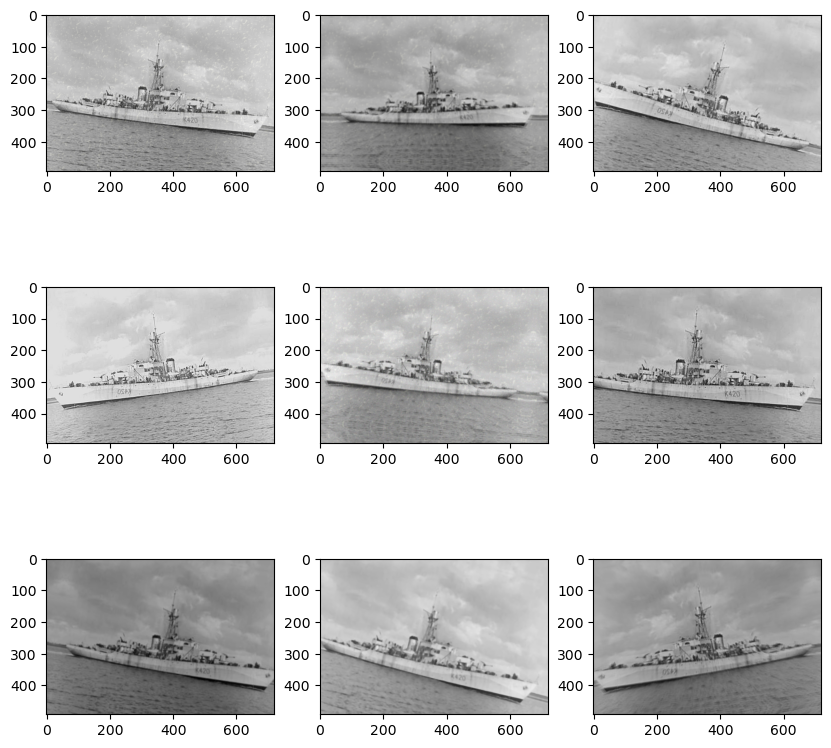

In [79]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.UnsharpMask(p=0.5),
    A.ZoomBlur(max_factor=1.05, p=.5),
    A.Spatter(intensity=0.1, p=.5),
    A.Sharpen(p=.5),
    A.Defocus(radius=3, p=0.1),
    A.RandomGamma(p=.5),
    A.RandomFog (fog_coef_lower=0.0, fog_coef_upper=0.2, p=0.5),
    A.MedianBlur(blur_limit=5, p=0.3),
    A.GaussianBlur(p=0.1),
    A.GaussNoise(p=0.1),
    A.ShiftScaleRotate(rotate_limit=15, p=1),
])

pil_image = Image.open(f"{train_ub}/56__HMS Kenilworth Castle (K 420)__TheRoyal Navy__Corvette__Castle.jpg")
image = np.array(pil_image)

fig = plt.figure(figsize=(10, 10))
for i in range(3*3):
    fig.add_subplot(3, 3, 1+i)
    plt.imshow(transform(image=image)['image'])

In [103]:
def augmentor(img):
    transform_and_resize = A.Compose([transform, A.Resize(256, 256, always_apply=True)])
    return preprocess_input(transform_and_resize(image=image)['image'])

In [104]:
augmentor(image).shape

(256, 256, 3)

In [135]:
rnet = ResNet50(include_top=False, pooling='avg', weights='imagenet')
model = Sequential()
model.add(rnet)
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

model.layers[0].trainable = False

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dense_13 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 25,949,830
Trainable params: 25,896,710
Non-trainable params: 53,120
_________________________________________________________________


In [136]:
optimizer = optimizers.Adam(lr = 0.001)
topk1 = TopKCategoricalAccuracy(k=1, name="topk1")
topk2 = TopKCategoricalAccuracy(k=2, name="topk2")
topk3 = TopKCategoricalAccuracy(k=2, name="topk3")
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1, topk1, topk2, topk3])

data_generator = ImageDataGenerator(preprocessing_function=augmentor)

In [131]:
train_generator = data_generator.flow_from_directory(train_ub, batch_size=8, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(valid_ub, batch_size=8, class_mode='categorical')

Found 760 images belonging to 6 classes.
Found 321 images belonging to 6 classes.


In [132]:
fit_history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/100
95/95 [==============================] - 125s 1s/step - loss: 1.7031 - f1: 0.0732 - topk1: 0.3526 - topk2: 0.6197 - topk3: 0.6197 - val_loss: 8.7902 - val_f1: 0.1016 - val_topk1: 0.1495 - val_topk2: 0.4548 - val_topk3: 0.4548
Epoch 2/100
95/95 [==============================] - 116s 1s/step - loss: 1.5394 - f1: 0.0371 - topk1: 0.3684 - topk2: 0.6539 - topk3: 0.6539 - val_loss: 5.0026 - val_f1: 0.2956 - val_topk1: 0.3178 - val_topk2: 0.6636 - val_topk3: 0.6636
Epoch 3/100
95/95 [==============================] - 117s 1s/step - loss: 1.5376 - f1: 0.0566 - topk1: 0.3789 - topk2: 0.6579 - topk3: 0.6579 - val_loss: 1.6017 - val_f1: 0.0914 - val_topk1: 0.3832 - val_topk2: 0.6729 - val_topk3: 0.6729
Epoch 4/100
95/95 [==============================] - 124s 1s/step - loss: 1.5385 - f1: 0.0206 - topk1: 0.3684 - topk2: 0.6632 - topk3: 0.6632 - val_loss: 1.7501 - val_f1: 0.1021 - val_topk1: 0.3209 - val_topk2: 0.6729 - val_topk3: 0.6729
Epoch 5/100
95/95 [=============================

KeyboardInterrupt: 

In [137]:
train_generator = data_generator.flow_from_directory(train_or, batch_size=8, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(valid_or, batch_size=8, class_mode='categorical')

Found 405 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [138]:
fit_history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/100
51/51 [==============================] - 58s 1s/step - loss: 1.8875 - f1: 0.1900 - topk1: 0.3457 - topk2: 0.5605 - topk3: 0.5605 - val_loss: 1.5320 - val_f1: 0.0000e+00 - val_topk1: 0.4678 - val_topk2: 0.6082 - val_topk3: 0.6082
Epoch 2/100
51/51 [==============================] - 53s 1s/step - loss: 1.5090 - f1: 0.1466 - topk1: 0.4222 - topk2: 0.6716 - topk3: 0.6716 - val_loss: 1.5386 - val_f1: 0.3336 - val_topk1: 0.4678 - val_topk2: 0.5556 - val_topk3: 0.5556
Epoch 3/100
51/51 [==============================] - 48s 946ms/step - loss: 1.5072 - f1: 0.1261 - topk1: 0.4444 - topk2: 0.6642 - topk3: 0.6642 - val_loss: 1.4895 - val_f1: 0.0409 - val_topk1: 0.4678 - val_topk2: 0.6608 - val_topk3: 0.6608
Epoch 4/100
51/51 [==============================] - 53s 1s/step - loss: 1.4784 - f1: 0.1114 - topk1: 0.4049 - topk2: 0.6963 - topk3: 0.6963 - val_loss: 1.5043 - val_f1: 0.0000e+00 - val_topk1: 0.4678 - val_topk2: 0.6608 - val_topk3: 0.6608
Epoch 5/100
51/51 [======================

KeyboardInterrupt: 